In [2]:
import pandas as pd
from src.core.Processing import Processing
from src.core.Analyser import Analyser
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

In [3]:
file_path="/home/khaldi/Documents/data_app_machine/creditcard.csv"
sep=","
outcome="Class"
positive_mod="1"

In [4]:
df=pd.read_csv(file_path,sep=sep)

In [5]:
process=Processing() # object which do processing for df
analyzer=Analyser() #object which give graphics, statistics indicators for df

In [6]:
df.shape

(284807, 31)

In [7]:
process.summary(df)

{'Missing Values': Time      0
 V1        0
 V2        0
 V3        0
 V4        0
 V5        0
 V6        0
 V7        0
 V8        0
 V9        0
 V10       0
 V11       0
 V12       0
 V13       0
 V14       0
 V15       0
 V16       0
 V17       0
 V18       0
 V19       0
 V20       0
 V21       0
 V22       0
 V23       0
 V24       0
 V25       0
 V26       0
 V27       0
 V28       0
 Amount    0
 Class     0
 dtype: int64,
 'Constant Features': []}

In [8]:
df[outcome]=df[outcome].astype(str) # cast outcome to qualitative variable

the dimension of df is (284807,31)
We can see that they don't have any missing values and constant features

0    0.998273
1    0.001727
Name: Class, dtype: float64

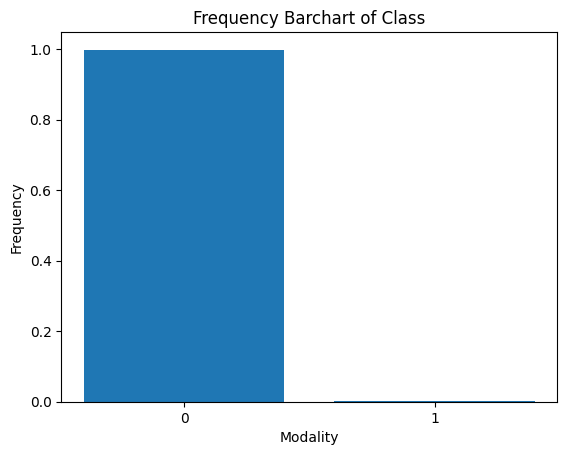

In [9]:
fig,ax=plt.subplots()
analyzer.bar_chart(df,outcome,ax,with_proportion=True)

We can see above that, Class attribute is very imbalanced ( 0.998 for modality "0")

In [10]:
analyzer_summary=analyzer.summary(df)
quantitatives,qualitatives=analyzer_summary["features"]["quantitative_columns"],analyzer_summary["features"]["qualitative_columns"]

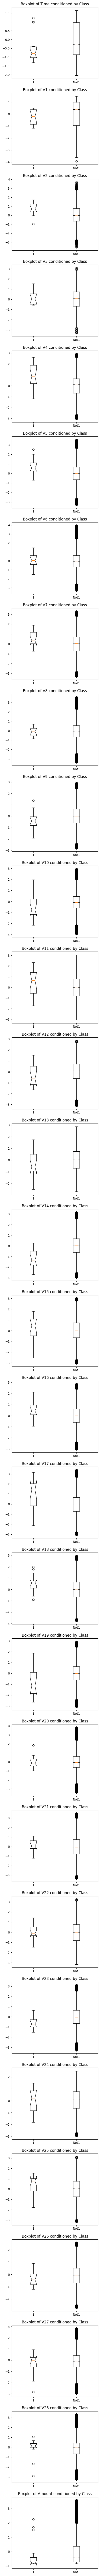

In [11]:
#we decided to remove outliers before boxplots creation
df=process.remove_outliers(df)
df[quantitatives]=process.standard_scaler(df[quantitatives]) #we also standardize quantitative features
fig,axs=plt.subplots(nrows=len(quantitatives),figsize=(5,len(quantitatives)*5))
for i in range(len(quantitatives)):
    analyzer.prop_churn_by_numerical_boxplot(df,outcome,positive_mod,quantitatives[i],axs[i])

- due to important numbers of features, we select variables with low, no influence for Class outcome:
    - Not/low influence: ["V22","V21","V19","V3"]

Conclusion -relevant quantitative features:
All except ["V22","V21","V19","V3"], to prevent overfitting risk, we are going to select a sub set of features most influents for Class outcome

In [12]:
relevant_features=list(set(quantitatives).difference({"V22","V21","V19","V3"}))
df_new=df[[outcome]+relevant_features] #we decided to work with only relevant features for Attrition

<Axes: >

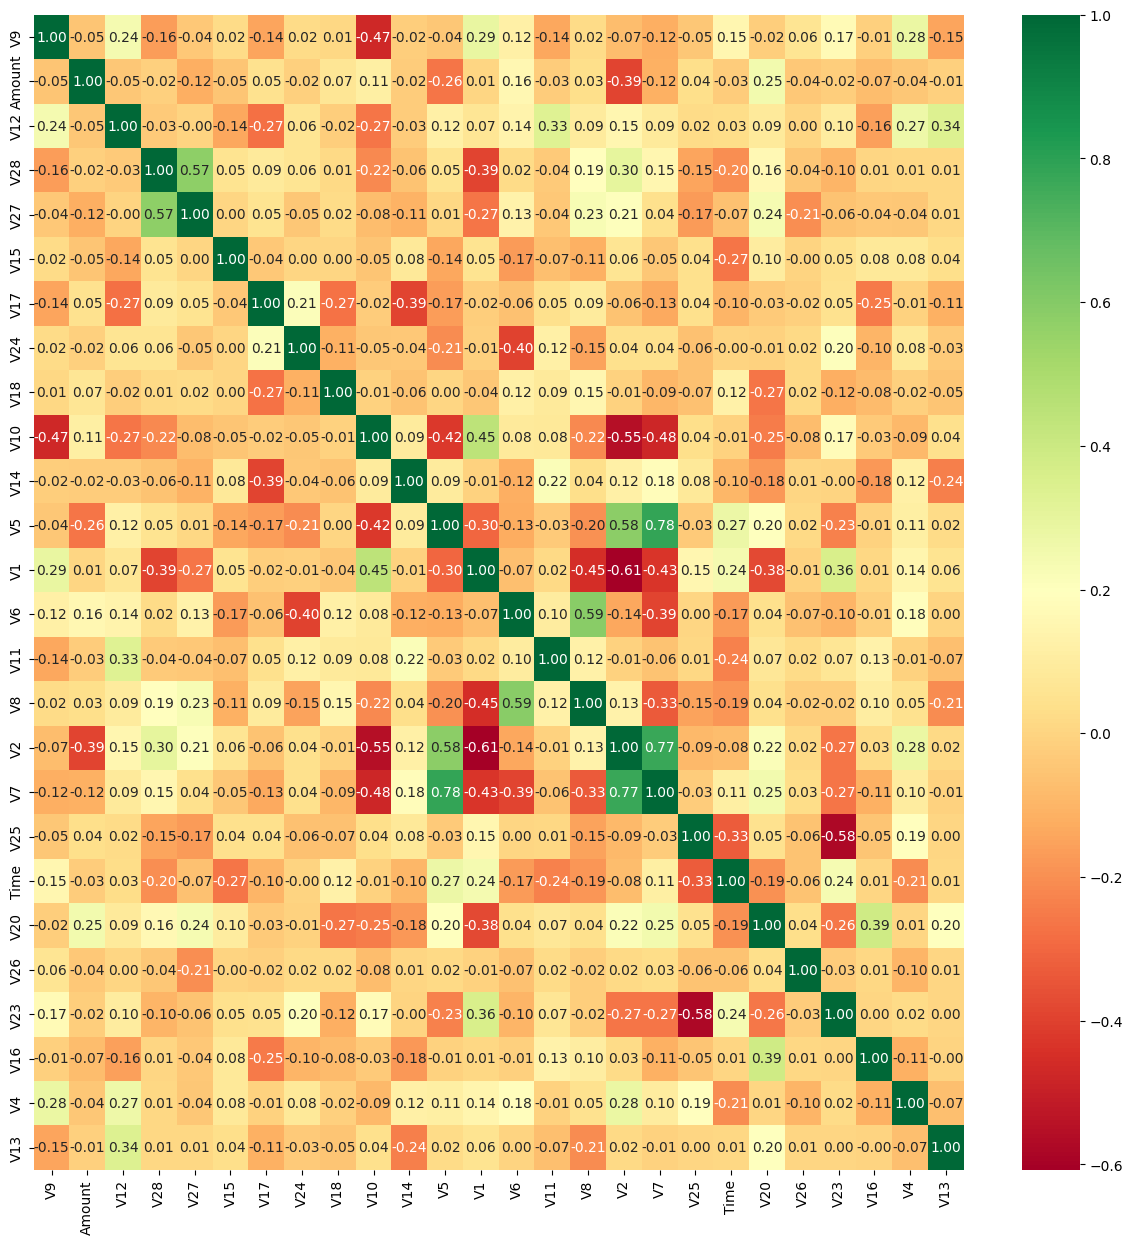

In [13]:
plt.figure(figsize=(15,15))
analyzer.correlation_heatmap(df_new,annot=True)

In [14]:
correlations=df_new.corr(numeric_only=True)
groups={1:.3,2:.5,3:.5}
"""
high correlation (>=.5): group3
medium correlation (>=.3 and <.5): group2
low correlation (<.3):group1
"""
print()

In [15]:
dict_correlations={key:[] for key in groups.keys()}
rows = cols = None

for group in groups.keys():
    if group==1:
        rows, cols =np.where(np.abs(correlations) < groups[group])
    elif group==2:
        rows, cols =np.where((np.abs(correlations) < groups[group]) & (np.abs(correlations) >= groups[group-1]))
    elif group==3:
        rows, cols =np.where(np.abs(correlations) >= groups[group])
    dict_correlations[group]=[(correlations.index[row], correlations.columns[col], correlations.iloc[row, col]) \
                              for row, col in zip(rows, cols) if row != col]

In [16]:
{
    group_number: dict_correlations[group_number]
        for group_number in dict_correlations.keys()
}

{1: [('V9', 'Amount', -0.05067736464145696),
  ('V9', 'V12', 0.24245522207340875),
  ('V9', 'V28', -0.1647396080762545),
  ('V9', 'V27', -0.04196476188360137),
  ('V9', 'V15', 0.021910099477789262),
  ('V9', 'V17', -0.14407874315926894),
  ('V9', 'V24', 0.02293623353859562),
  ('V9', 'V18', 0.012010136735616099),
  ('V9', 'V14', -0.02243445850340917),
  ('V9', 'V5', -0.043301885931174795),
  ('V9', 'V1', 0.28831015996599985),
  ('V9', 'V6', 0.11785816198832796),
  ('V9', 'V11', -0.14101025240291748),
  ('V9', 'V8', 0.02420403394122642),
  ('V9', 'V2', -0.0738807179016549),
  ('V9', 'V7', -0.12097867317737628),
  ('V9', 'V25', -0.0454311175831085),
  ('V9', 'Time', 0.14693361867597968),
  ('V9', 'V20', -0.020032586273537194),
  ('V9', 'V26', 0.058850454255475866),
  ('V9', 'V23', 0.1689748999682559),
  ('V9', 'V16', -0.012712587533643759),
  ('V9', 'V4', 0.28392048374626433),
  ('V9', 'V13', -0.14689673123542824),
  ('Amount', 'V9', -0.05067736464145696),
  ('Amount', 'V12', -0.04763381

We can see that this tuple features have abs(correlation)>=.5
[
  ('V23', 'V25', -0.5812886668266443),
  ('V1', 'V2', -0.607644959168512),
  ('V8', 'V6', 0.5861803360059155),
  ('V28', 'V27', 0.5736721045524082),
  ('V5', 'V2', 0.5841723999780843),
  ('V5', 'V7', 0.7820080661264317),
  ('V2', 'V10', -0.5535632809828112),
  ('V2', 'V7', 0.7692226619224113)
]
We decided to remove ["V23","V1","V8","V27","V5","V2"] to avoid as much as possible correlations between features

In [17]:
removed_features=["V23","V1","V8","V27","V5","V2"]
relevant_features=[f for f in relevant_features if f not in removed_features]
df_new_=df_new[[outcome]+relevant_features]

In [18]:
process.summary(df_new_)

{'Missing Values': Class     0
 V9        0
 Amount    0
 V12       0
 V28       0
 V15       0
 V17       0
 V24       0
 V18       0
 V10       0
 V14       0
 V6        0
 V11       0
 V7        0
 V25       0
 Time      0
 V20       0
 V26       0
 V16       0
 V4        0
 V13       0
 dtype: int64,
 'Constant Features': []}

In [19]:
analyzer.summary(df_new_)

{'features': {'qualitative_columns': ['Class'],
  'quantitative_columns': ['V9',
   'Amount',
   'V12',
   'V28',
   'V15',
   'V17',
   'V24',
   'V18',
   'V10',
   'V14',
   'V6',
   'V11',
   'V7',
   'V25',
   'Time',
   'V20',
   'V26',
   'V16',
   'V4',
   'V13']},
 'describe':                  V9        Amount           V12           V28           V15  \
 count  1.463340e+05  1.463340e+05  1.463340e+05  1.463340e+05  1.463340e+05   
 mean  -1.243039e-17 -6.992097e-17 -6.370577e-17 -3.107599e-18  2.175319e-17   
 std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
 min   -2.814511e+00 -8.343829e-01 -3.113951e+00 -3.260569e+00 -3.047714e+00   
 25%   -5.984735e-01 -7.296545e-01 -6.217675e-01 -6.718029e-01 -6.611799e-01   
 50%    1.801707e-03 -4.381844e-01  8.081816e-02 -2.592689e-03  4.405784e-02   
 75%    6.263627e-01  3.611466e-01  7.081461e-01  4.175231e-01  7.299755e-01   
 max    2.911573e+00  3.577121e+00  2.847550e+00  3.330720e+00  3.018557e+

In [20]:
###END OF SESSION 1

In [21]:
from src.core.ComputeModel import ComputeModel
from src.core.globals import MODEL_HYPERPARAMETERS_DEF
import copy

positive_mod="1"
models={"Logistic Regression":None,
        "SVM":None,
        "DecisionTreeClassifier":None
        }

In [ ]:
#we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None
    models[model_name]=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                                    process=process,model_name=model_name,\
                                    hyperparameters=hyperparameters,positive_mod=positive_mod,stratify=False)
    models[model_name].fit()

In [ ]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_default={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}

In [23]:
metrics_default

{'Logistic Regression': {'auc': 0.8511937306360489,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'SVM': {'auc': 0.533465463823583,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'DecisionTreeClassifier': {'auc': 0.4999145708037179,
  'accuracy': 0.9997266545939112,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0}}

In conclusion:
we set up three models, DecisionTreeClassifier, SVM, Logistic Regression:
we use AUC metrics because it's metrics that allow to see False positive Rate and True Positive Rate, and as dataset is imbalanced, accuracy in this case is not relevant
- We can see that  Logistic Regression is the best model because AUC of this model (~0.85) is significantly bigger than auc for 2 others models
- We can see that probabity to be positive is very very low, consequently recall and precision are equal to 0 because dataset is very very imbalanced (~99.8% negative ~0.02% positive)
- To conclude, models are not efficient for this dataset, we need to have a oversampling/undersampling methods to balanced majority and minority class for Class outcome, we have decided to actualy work with imbalanced dataset in this sequence because in sequence 4, we will see over/under sampling methods
- Simplify conclusion: Logistic Regression > SVM > DecisionTreeClassifier (with default hyperparameters)




In [35]:
params_grid= \
    {
        "Logistic Regression": \
            {
                "penalty": ["l2"],
                "C": np.logspace(-3, 3, 7),
                "solver": ["lbfgs"],
                "multi_class": ["auto"],
                "n_jobs": [None],
                "max_iter": [200,250]
            },
        "SVM":
            {
                "kernel": ["poly", "rbf", "sigmoid"],
                "C": [0.1, 1, 10, 100],
                "degree": [3],
                "gamma": [1, 0.1, 0.01, 0.001]

            },
        "DecisionTreeClassifier":
            {
                "criterion": ["gini"],
                "splitter": ["best"],
                "max_depth": [None],
                "min_samples_split": [2, 3, 4],
                "min_samples_leaf": [1],
                "min_weight_fraction_leaf": [0.],
                "max_features": [None],
                "random_state": [None],
                "max_leaf_nodes": [None]+list(range(2, 100)),
                "min_impurity_decrease": [0.],
                "class_weight": [None],
                "ccp_alpha": [0.]
            }

    }


In [25]:
#we used 3 fold cross validation with a params default grid located in globals file (in src directory)
for model_name in models.keys():
    models[model_name]=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                                    process=process,model_name=model_name,\
                                    positive_mod=positive_mod,grid_search=True,cv=3,params_grid=params_grid[model_name],stratify=False)
    models[model_name].fit()

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 297 candidates, totalling 891 fits


/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-ZfQQWeXB-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-ZfQQWeXB-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-ZfQQWeXB-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

{'Logistic Regression': {'auc': 0.5720794605431019,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'SVM': {'auc': 0.25343994897029337,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'DecisionTreeClassifier': {'auc': 0.4994190814652816,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0}}

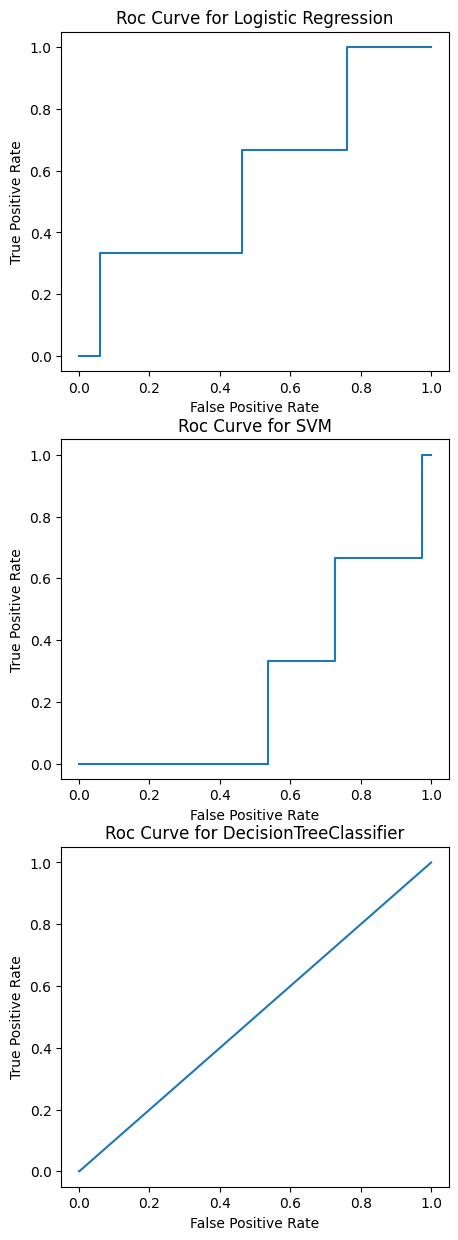

In [26]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics

In [27]:
resume_tuned=pd.DataFrame(metrics)
resume_default=pd.DataFrame(metrics_default)

In [28]:
pd.concat([resume_tuned.T,resume_default.T])\
    .reset_index()\
    .groupby("index")\
    .agg(lambda x:[a for a in x])
#first component of tuple is metric for hyperparameters tuning

,auc,accuracy,precision,recall,f1_score
index,,,,,
DecisionTreeClassifier,"[0.4994190814652816, 0.4999145708037179]","[0.9998974954727167, 0.9997266545939112]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"
Logistic Regression,"[0.5720794605431019, 0.8511937306360489]","[0.9998974954727167, 0.9998974954727167]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"
SVM,"[0.25343994897029337, 0.533465463823583]","[0.9998974954727167, 0.9998974954727167]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"


- We can see that SVM are significantly decrease in term of performance (auc: 0.533 to .25), DecisionTreeClassifier stay at the same order of values.
  But with tuning, LogisticRegression, auc decrease, accuracy stay constant (.99), precision, recall, f1_score stay equal to 0
- An important things: metrics after tuning are more reliable because a 3 fold cross validation are set up during training whereas with default hyperparameters this 3 cross validation was not done (1 test set and 1 training set), that's why some indicators don't increase or decrease after tuning.
- Conclusion: even if you are using grid search, the best model for each three type of model don't resolve the problem of imbalance dataset;
  We need to equilibrate dataset and after train a model, I think that they are a huge imbalance between majority and minority modality for Class outcome
  and consequently all 3 models don't see minority class and predict always majority class.
  Logistic Regression with 3 cross validation (auc~0.572) seems be the best of all models trained.

In [48]:
hyperparameters_tuned={list(models.keys())[i]:models[list(models.keys())[i]].model.hyperparameters for i in range(len(models.keys()))}

In [49]:
hyperparameters_tuned

{'Logistic Regression': {'C': 0.001,
  'max_iter': 200,
  'multi_class': 'auto',
  'n_jobs': None,
  'penalty': 'l2',
  'solver': 'lbfgs'},
 'SVM': {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'},
 'DecisionTreeClassifier': {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': 2,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'}}

In [50]:
best_model,hyperparameters_best=models["Logistic Regression"],hyperparameters_tuned["Logistic Regression"]

In [32]:
###END OF SESSION 2

In [52]:
model_gradient=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                            process=process,model_name="GradientBoostingClassifier", \
                            positive_mod=positive_mod,grid_search=True,cv=3)
model_gradient.fit()

Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [74]:
model_gradient.metrics()

{'auc': 0.7005137142336432,
 'accuracy': 0.9998633272969556,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0}

In [54]:
model_random=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                          process=process,model_name="RandomForestClassifier", \
                          positive_mod=positive_mod,grid_search=True)
model_random.fit()

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [69]:
model_random.metrics() #Random forest is not better than SVM (auc ~0.64)

/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-ZfQQWeXB-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'auc': 0.6841625660652451,
 'accuracy': 0.9998974954727167,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0}

We can see that two model don't resolve problem of imbalanced dataset, but auc is better for GradientBoostingClassifier than for RandomForestClassifier with cross validation in objective of reducing variance of the model

In [70]:
from matplotlib import pyplot
hyperparameters_best=model_gradient.model.hyperparameters

In [81]:
best_model=model_gradient.model.model

In [82]:
hyperparameters_best

{'learning_rate': 0.001, 'n_estimators': 1500}

In [83]:
best_model

GradientBoostingClassifier(learning_rate=0.001, n_estimators=1500)

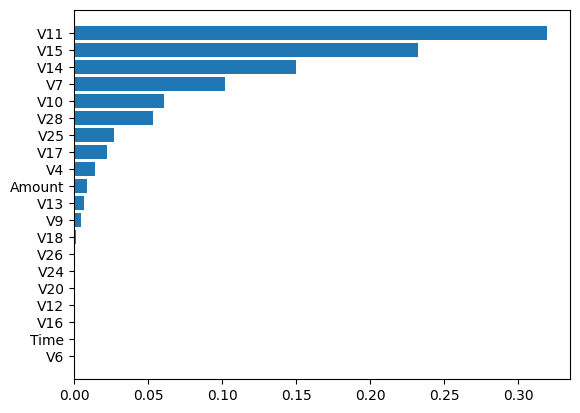

In [84]:
importances=best_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(model_random.dict_split["columns_features"])[indices])

top 6 influent features : "V11", "V15", "V14", "V7", "V10", "V28"

In [90]:
model_seq3=best_model

In [91]:
hyperparameters_best

{'learning_rate': 0.001, 'n_estimators': 1500}

In [92]:
model_seq3

GradientBoostingClassifier(learning_rate=0.001, n_estimators=1500)

In [46]:
###END OF SESSION 3

In [23]:
models={"Logistic Regression":None,
        #"SVM":None, # training for SVM take a long time
        "DecisionTreeClassifier":None,
        "RandomForestClassifier": None,
        "GradientBoostingClassifier":None
        }

In [22]:
df_new_[[e for e in relevant_features if e in quantitatives]]=process.standard_scaler(df_new_[[e for e in relevant_features if e in quantitatives]])

/tmp/ipykernel_194113/4022361902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_[[e for e in relevant_features if e in quantitatives]]=process.standard_scaler(df_new_[[e for e in relevant_features if e in quantitatives]])


In [23]:
import copy
#we use liblinear solver because Gradient descent don't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None
    models[model_name]=ComputeModel(
        df_new_[relevant_features],df_new_[outcome],
        process=process,model_name=model_name,
        hyperparameters=hyperparameters,positive_mod=positive_mod
    )
    models[model_name].fit()

/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-ZfQQWeXB-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-ZfQQWeXB-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Logistic Regression': {'auc': 0.6143498268634955,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'DecisionTreeClassifier': {'auc': 0.49996582832148717,
  'accuracy': 0.9998291591211945,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'RandomForestClassifier': {'auc': 0.49567728266812466,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'GradientBoostingClassifier': {'auc': 0.7172749225441953,
  'accuracy': 0.9997949909454334,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0}}

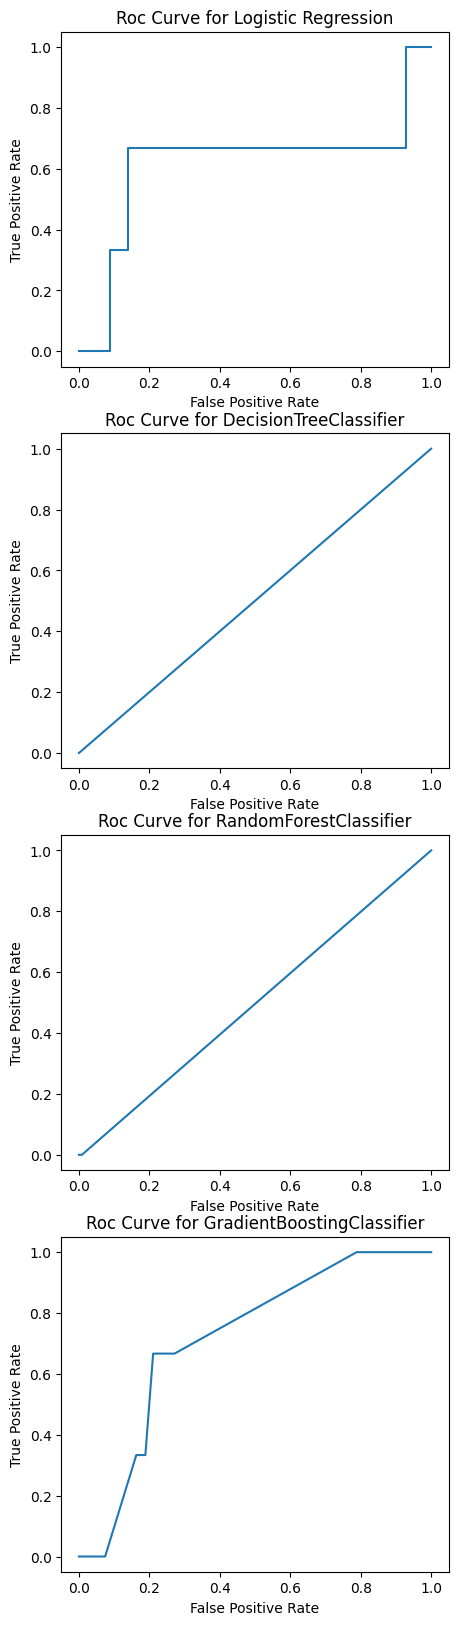

In [24]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_default={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics_default

In [31]:
#we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None
    models[model_name]=ComputeModel(
        df_new_[relevant_features],df_new_[outcome],
        process=process,model_name=model_name,
        hyperparameters=hyperparameters,positive_mod=positive_mod
    )
    models[model_name].fit(sampling=True,method="SMOTE")

{'Logistic Regression': {'auc': 0.9643327488867767,
  'accuracy': 0.9050369054127939,
  'precision': 0.8983130586732979,
  'recall': 0.9134773100054675,
  'f1_score': 0.9058317237640201},
 'DecisionTreeClassifier': {'auc': 0.9997095407326407,
  'accuracy': 0.9997095407326407,
  'precision': 0.9995217762596071,
  'recall': 0.9998974849644614,
  'f1_score': 0.9997095953125266},
 'RandomForestClassifier': {'auc': 1.0,
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1_score': 1.0},
 'GradientBoostingClassifier': {'auc': 0.9999596243121947,
  'accuracy': 0.9970270639693821,
  'precision': 0.9940892723690468,
  'recall': 1.0,
  'f1_score': 0.9970358761200641}}

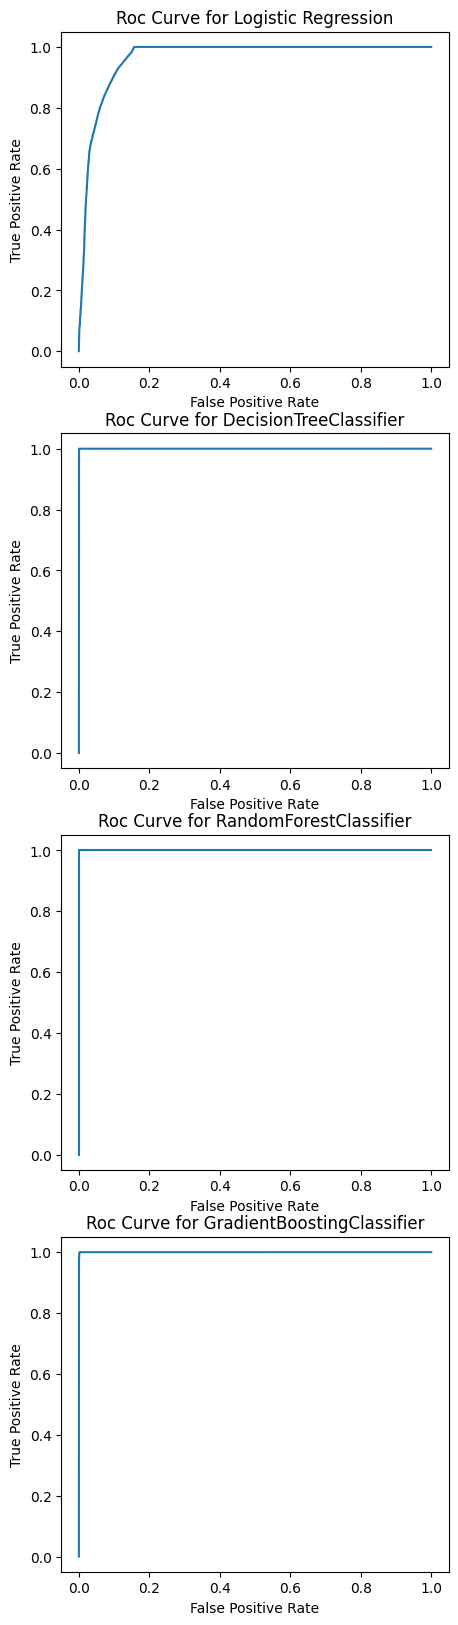

In [32]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_default_b={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics_default_b


We can see with default hyperparameters that with oversampling, metrics of models improve significantly, precisely precision, recall and f1-score increase (~0.9 and more for all models). Means that oversampling works and models don’t have a bias for majority class and can predict minority class frequently (that’s why precision, recall, f1-score increase). The best model with default hyperparameter is RandomForestClassifier (1 for auc, 1 for recall etc..).The roc curve have a beautiful curve (concave curve) But to have a relevant conclusion, we need to find the best model with a grid search and cross validation. Because even if the metrics are high for the model, there is one test set and one training set and so even if the bias of the model is small but variance can be high and consequently, the predictions for the model can have a variability with the training set (overfitting). I think that this model overfit the data, that's why metrics are a very high values for all models. Logistic Regression seems to be the worst of all models but metrics evaluation are very good. To clarify if models overfit or not, we are going to use cross validation to try to kill overfitting.

In [25]:
#we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None
    models[model_name]=ComputeModel(
        df_new_[relevant_features],df_new_[outcome],
        process=process,model_name=model_name,
        hyperparameters=hyperparameters,positive_mod=positive_mod
    )
    models[model_name].fit(sampling=True,method="RandomUnderSampling")

{'Logistic Regression': {'auc': 0.7222222222222222,
  'accuracy': 0.6666666666666666,
  'precision': 0.5,
  'recall': 0.3333333333333333,
  'f1_score': 0.4},
 'DecisionTreeClassifier': {'auc': 0.5,
  'accuracy': 0.5555555555555556,
  'precision': 0.3333333333333333,
  'recall': 0.3333333333333333,
  'f1_score': 0.3333333333333333},
 'RandomForestClassifier': {'auc': 0.9444444444444445,
  'accuracy': 0.8888888888888888,
  'precision': 1.0,
  'recall': 0.6666666666666666,
  'f1_score': 0.8},
 'GradientBoostingClassifier': {'auc': 0.8055555555555556,
  'accuracy': 0.7777777777777778,
  'precision': 1.0,
  'recall': 0.3333333333333333,
  'f1_score': 0.5}}

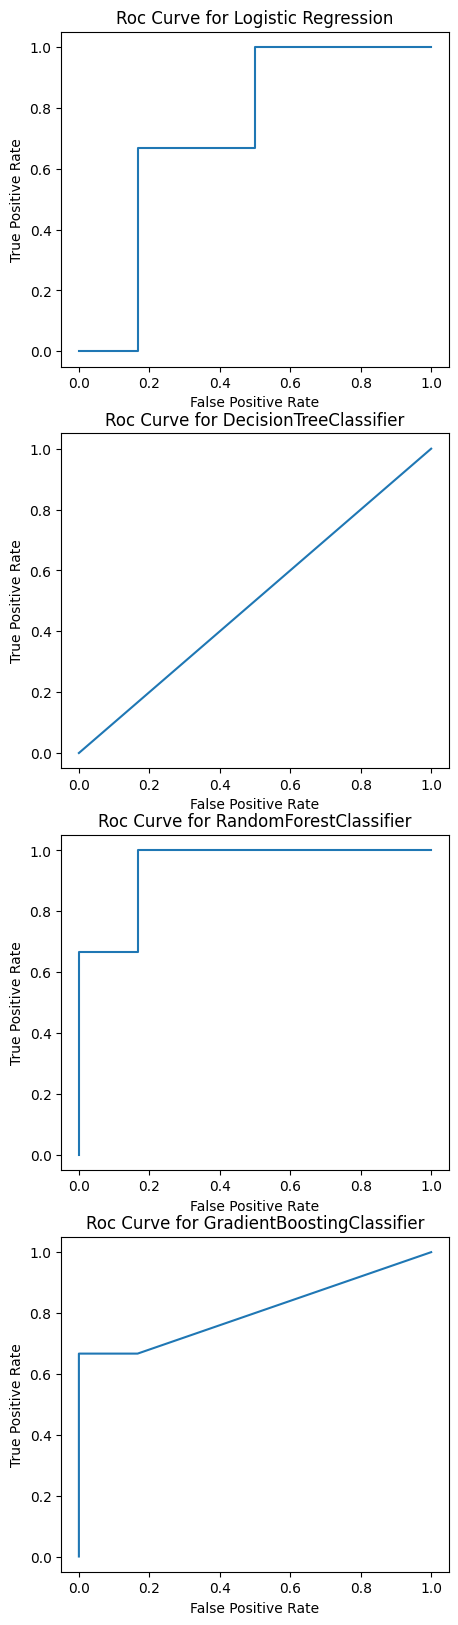

In [26]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_default_bunder={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics_default_bunder

With undersampling, we can see that all models (exception for RandomForestClassifier are not good, the metrics are small comparing to situation with oversampling. I think that as the proportion of minority class (fraud) is very small comparing to proportion of non fraud rows, models underfit the data, the dataset with undersampling don't have lot of informations to learn how to recognize majority class/ minority class. So we have this hypothesis: as the proportion of fraud rows is very small, underfitting implies underfit of the datas and overfitting implies overfit of the datas.
The best models seems to be in this situation RandomForestClassifier

In [21]:
params_grid= \
    {
        "Logistic Regression": \
            {
                "penalty": ["l2"],
                "C": np.logspace(-3, 3, 7),
                "solver": ["lbfgs"],
                "multi_class": ["auto"],
                "n_jobs": [None],
                "max_iter": [200,250]
            },
        "DecisionTreeClassifier":
            {
                "criterion": ["gini"],
                "splitter": ["best"],
                "max_depth": [None],
                "min_samples_split": [2, 3, 4],
                "min_samples_leaf": [1],
                "min_weight_fraction_leaf": [0.],
                "max_features": [None],
                "random_state": [None],
                "max_leaf_nodes": [None]+list(range(2, 100)),
                "min_impurity_decrease": [0.],
                "class_weight": [None],
                "ccp_alpha": [0.]
            },
        "RandomForestClassifier":
            {
                "n_estimators":list(np.random.randint(50,500,size=5)),
                "max_depth":list(np.random.randint(1,20,size=5))
            },
        "GradientBoostingClassifier":
            {
                "learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001],
                "n_estimators":[100,250,500,750,1000,1250,1500,1750]
            }

    }


In [25]:
#we used 3 fold cross validation with a params default grid located in globals file (in src directory)
for model_name in models.keys():
    models[model_name]=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                                    process=process,model_name=model_name, \
                                    positive_mod=positive_mod,grid_search=True,cv=3,params_grid=params_grid[model_name],stratify=False)
    models[model_name].fit(sampling=True,method="SMOTE")

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 297 candidates, totalling 891 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'Logistic Regression': {'auc': 0.9645012741795403,
  'accuracy': 0.9070872061235647,
  'precision': 0.8999499916652776,
  'recall': 0.91719615371547,
  'f1_score': 0.9084912327937267},
 'DecisionTreeClassifier': {'auc': 0.9995719625498203,
  'accuracy': 0.9995728540185894,
  'precision': 0.9994225543478261,
  'recall': 0.9997281777717373,
  'f1_score': 0.9995753426984423},
 'RandomForestClassifier': {'auc': 0.9999997921419879,
  'accuracy': 0.9988894204483324,
  'precision': 0.9977963113642527,
  'recall': 1.0,
  'f1_score': 0.9988969402820439},
 'GradientBoostingClassifier': {'auc': 1.0,
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1_score': 1.0}}

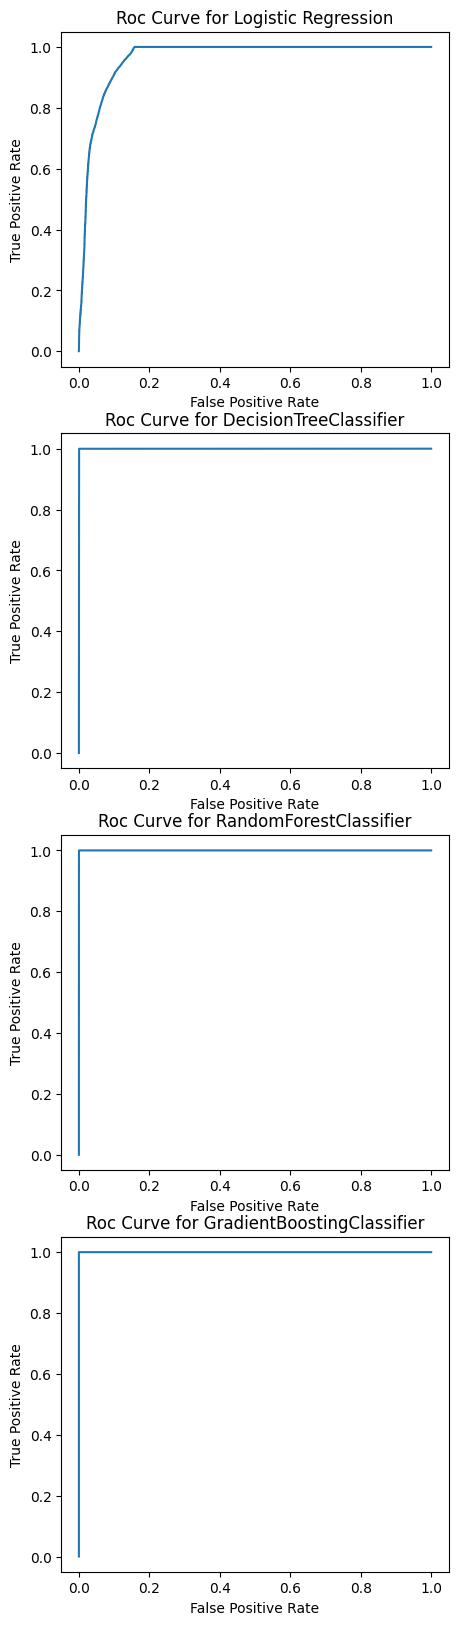

In [26]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_b={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics_b

a training of the models was very long, we use cv=3 to be able to train the models (even if more cv is high, more it is better).
Same conclusion that before without cross validation.Results of models (precisely Decision Trees) have a very high values for all metrics.
And the result is more reliable with cross validation (3 training set so 3 evaluation for metrics), but the results of metrics is the same that without cross
validation. So they are hypothesis:
- the first hypothesis is that models have a small bias and a small variance, so models don't overfit the dataset and don't underfit the dataset, so Decision Trees are the best models
- the second hypothesis that, models overfit the dataset and we need to increase cv (10 fold, 20fold...)

In [27]:
{key:model.model.hyperparameters for key,model in zip(models.keys(),models.values())}

{'Logistic Regression': {'C': 1000.0,
  'max_iter': 200,
  'multi_class': 'auto',
  'n_jobs': None,
  'penalty': 'l2',
  'solver': 'lbfgs'},
 'DecisionTreeClassifier': {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'},
 'RandomForestClassifier': {'max_depth': 18, 'n_estimators': 482},
 'GradientBoostingClassifier': {'learning_rate': 0.15, 'n_estimators': 1750}}

In [28]:
#we used 3 fold cross validation with a params default grid located in globals file (in src directory)
for model_name in models.keys():
    models[model_name]=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                                    process=process,model_name=model_name, \
                                    positive_mod=positive_mod,grid_search=True,cv=3,params_grid=params_grid[model_name],stratify=False)
    models[model_name].fit(sampling=True,method="RandomUnderSampling")

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 297 candidates, totalling 891 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'Logistic Regression': {'auc': 0.85,
  'accuracy': 0.6666666666666666,
  'precision': 1.0,
  'recall': 0.25,
  'f1_score': 0.4},
 'DecisionTreeClassifier': {'auc': 0.75,
  'accuracy': 0.7777777777777778,
  'precision': 1.0,
  'recall': 0.5,
  'f1_score': 0.6666666666666666},
 'RandomForestClassifier': {'auc': 1.0,
  'accuracy': 0.7777777777777778,
  'precision': 1.0,
  'recall': 0.5,
  'f1_score': 0.6666666666666666},
 'GradientBoostingClassifier': {'auc': 1.0,
  'accuracy': 0.8888888888888888,
  'precision': 1.0,
  'recall': 0.75,
  'f1_score': 0.8571428571428571}}

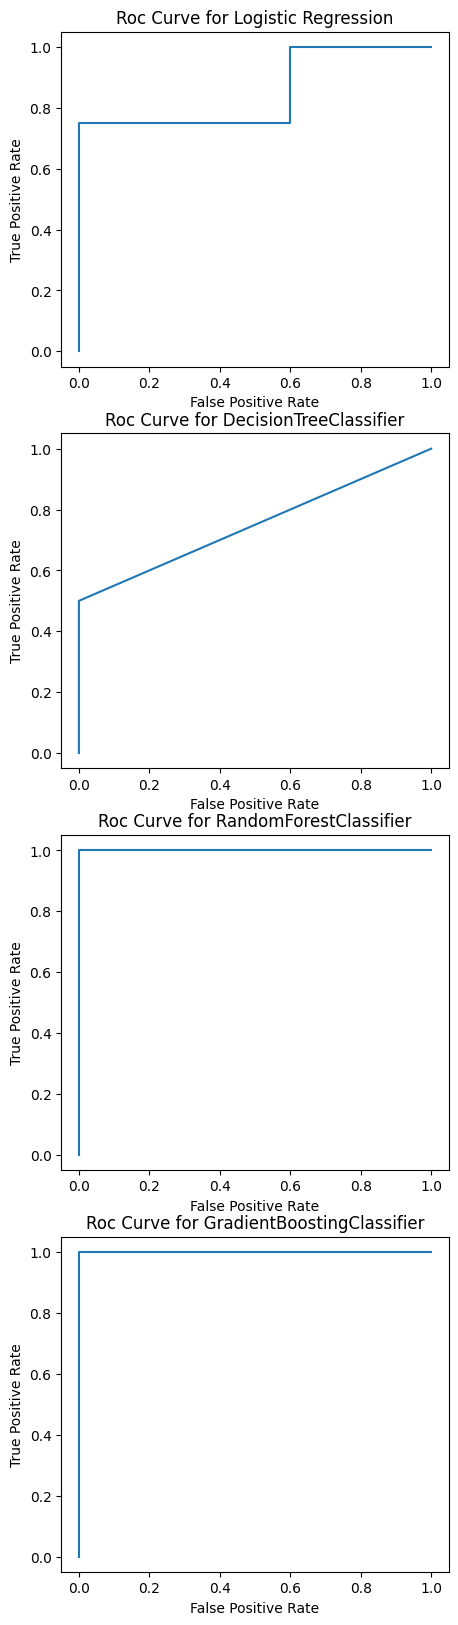

In [29]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_bunder={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics_bunder

grid search with undersampling:
recall and f1-score for all models are smaller than recall f1-score with oversampling, implies that false negative rate are more important with undersampling. In our case implies with the fact that the positive modality is the minority class, models have a bias for the majority class even if we have done a undersampling.
Only GradientBoostingClassifier have a good recall (~0.75).
best model for this approach: GradientBoostingClassifier

In [30]:
{key:model.model.hyperparameters for key,model in zip(models.keys(),models.values())}

{'Logistic Regression': {'C': 0.09999999999999999,
  'max_iter': 200,
  'multi_class': 'auto',
  'n_jobs': None,
  'penalty': 'l2',
  'solver': 'lbfgs'},
 'DecisionTreeClassifier': {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': 2,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'},
 'RandomForestClassifier': {'max_depth': 3, 'n_estimators': 263},
 'GradientBoostingClassifier': {'learning_rate': 0.001, 'n_estimators': 500}}

In [22]:
hyperparams_opti={
    "GradientBoostingClassifier":
        {
            "learning_rate":0.15,
            "n_estimators":1750
        },
    "RandomForestClassifier":
        {

            "max_depth": 18,
            "n_estimators": 482
        }

}
#To conclude, this 2 models are the best for this dataset, we choose the model with a model with fewer parameters to reduce variance of the model.
#RandomForestClassifier have less estimators than "GradientBoostingClassifier", we choose it to simplify the model.

In [28]:
from src.core.ComputeModel import ComputeModel
best_models={
    "RandomForestClassifier":
        ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                     process=process,model_name="RandomForestClassifier", \
                     positive_mod=positive_mod,grid_search=False,params_grid=hyperparams_opti["RandomForestClassifier"],stratify=False)
}

In [30]:
p=.15
best_models["RandomForestClassifier"].fit(sampling=True,method="SMOTE",perc_minority=p)
while best_models["RandomForestClassifier"].metrics()["f1_score"] < .901:
    best_models["RandomForestClassifier"].fit(sampling=True,method="SMOTE",perc_minority=p)
    p+=.1

In [31]:
"Percentage of minority class: " + str(round((p/(p+1))*100,2)) +"%" #13.04% percentage of minority class with oversampling for f1_score >=0.901

'Percentage of minority class: 13.04%'

{'auc': 1.0,
 'accuracy': 0.9999405717002436,
 'precision': 1.0,
 'recall': 0.999547203984605,
 'f1_score': 0.9997735507246377}

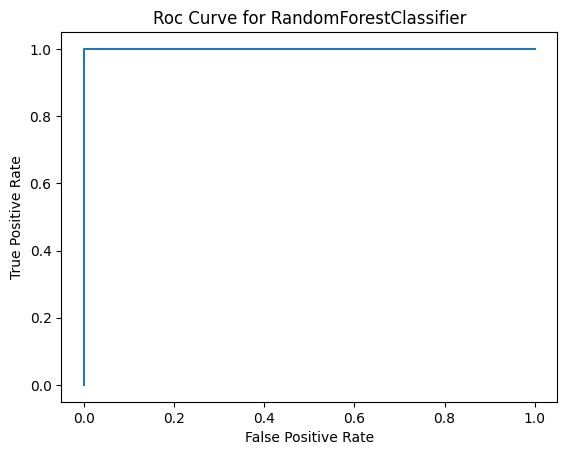

In [33]:
fig,ax=plt.subplots()
best_models["RandomForestClassifier"].metrics(plot_roc=True,ax=ax)

In [43]:
bias_two,variance=best_models["RandomForestClassifier"].bias_variance_estimate(bootstrap_rounds=191)

/home/khaldi/Documents/unbalanced-data-ml/src/core/ComputeModel.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  preds_test[f'Model {r}'] = estimator.fit(np.array(X_train.iloc[boot, :]), np.array(y_train.iloc[boot]).ravel()).predict(X_test)
/home/khaldi/Documents/unbalanced-data-ml/src/core/ComputeModel.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  preds_test[f'Model {r}'] = estimator.fit(np.array(X_train.iloc[boot, :]), np.array(y_train.iloc[boot]).ravel()).predict(X_test)
/home/khaldi/Documents/unbalanced-data-ml/

In [44]:
print(f"Finally: Bias²: {bias_two} and Variance: {variance}")

Finally: Bias²: 1.708583925641438e-05 and Variance: 7.603645742383363e-06


In [37]:
"(1.708583925641438e-05, 8.201202843078903e-06)"

'(1.708583925641438e-05, 8.201202843078903e-06)'